In [1]:
# [Reference code] http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/GMM/GMM.ipynb

# Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal

# Gaussian Mixture Model

Clustering methods such as **K-means** have hard boundaries, meaning a data point either belongs to that cluster or it doesn't. On the other hand, clustering methods such as **Gaussian Mixture Models (GMM)** have soft boundaries, where data points can belong to multiple cluster at the same time but with different degrees of belief. e.g. a data point can have a 60% of belonging to cluster 1, 40% of belonging to cluster 2.

Apart from using it in the context of clustering, one other thing that **GMM** can be useful for is outlier detection: Due to the fact that we can compute the likelihood of each point being in each cluster, the points with a "relatively" low likelihood (where "relatively" is a threshold that we just determine ourselves) can be labeled as outliers. But here we'll focus on the clustering application.

## Gaussian Distribution

In **GMM**, each cluster corresponds to a probability distribution, in this case the Gaussian distribution. What we want to do is to learn the parameters of these distributions, which is the Gaussian's mean $\mu$ (mu), and the variance $\sigma^2$ (sigma).

The mathematical form of the Gaussian distribution in 1-dimension (univariate Gaussian) can be written as:

$$N(x \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}$$

- This is also referred to as the probability density function (pdf).
- Gaussian distribution is commonly referred to as the Normal distribution, hence that's where the $N$ comes from.
- $x$ refers to the random observation over which this distribution is placed.
- The mean $\mu$, controls the Gaussian's "center position" and the variance $\sigma^2$, controls its "shape". To be precise, it is actually the standard deviation $\sigma$, i.e. the square root of the variance that controls the distribution's shape.

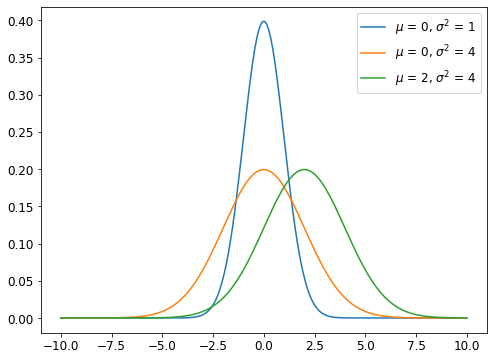

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# gaussian distribution with different values of the mean and variance
x = np.linspace(start = -10, stop = 10, num = 200)
mean_opt = [0, 0, 2]
var_opt = [1, 4, 4]

for m, v in zip(mean_opt, var_opt):
    y = norm(m, np.sqrt(v)).pdf(x)
    plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(m, v))
    plt.legend()

plt.show()

But that was in one dimesion, what about two, three, four ... It turns out the univariate (one-dimensional) gaussian can be extended to the multivariate (multi-dimensional) case. The form of a d-dimensional gaussian:

$$N(x \mid \mu,\Sigma) = \frac{1}{(2\pi)^{d/2}\sqrt{|\Sigma|}}exp(-\dfrac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu))$$

In higher dimensions, a Gaussian is fully specified by a mean vector $\boldsymbol{\mu}$ and a d-by-d covariance matrix, $\boldsymbol{\Sigma}$ (do not confused this symbol with $\sum$, which is used for denoting summing a bunch of stuff). $|\Sigma|$ refers to the determinant of the covariance matrix e.g. In two dimension, the Gaussian's parameters might look like this:

$$N
\begin{bmatrix}
\begin{pmatrix}
\mu_1\\
\mu_2
\end{pmatrix}\, ,
\begin{pmatrix}
\sigma^2_1 & \sigma_{12} \\
\sigma_{21} & \sigma^2_2
\end{pmatrix}
\end{bmatrix}
$$

The mean vector, containing elements $\mu_1$ and $\mu_1$ centers the distribution along every dimension. On the other hand, the covariance matrix specifies the spread and orientation of the distribution. Along the diagonal of this covariance matrix we have the variance terms $\sigma^2_1$ and $\sigma^2_2$ representing the shape (spread) along each of the dimensions. But then we also have the off-diagonal terms, $\sigma_{12}$ and $\sigma_{21}$ (these two thing actually take the same value because this a symmetric matrix) that specify the correlation structure of the distribution.

Let's look at a few examples of covariance structures that we could specify.

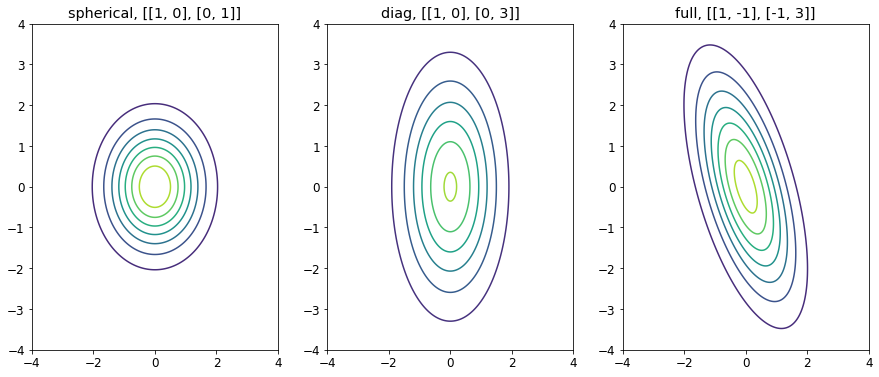

In [4]:
# revised from
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
x, y = np.mgrid[-4:4:.01, -4:4:.01]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y

# different values for the covariance matrix
covariances = [ [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, -1], [-1, 3]] ]
titles = ['spherical', 'diag', 'full']

plt.figure(figsize = (15, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    z = multivariate_normal([0, 0], covariances[i]).pdf(position)
    plt.contour(x, y, z)
    plt.title('{}, {}'.format(titles[i], covariances[i]))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.show()

One way to view a Gaussian distribution in two dimensions is what's called a contour plot. The coloring represents the region's intensity, or how high it was in probability. So in the plot above, the center area that has dark red color is the region of highest probability, while the blue area corresponds to a low probability.

The first plot is refered to as a **Spherical Gaussian**, since the probability distribution has spherical (circular) symmetry. The covariance matrix is a diagonal covariance with equal elements along the diagonal. By specifying a diagonal covariance, what we're seeing is that there's no correlation between our two random variables, because the off-diagonal correlations takes the value of 0. Furthermore, by having equal values of the variances along the diagonal, we end up with a circular shape to the distribution because we are saying that the spread along each one of these two dimensions is exactly the same. 
 
In contrast, the middle plot's covariance matrix is also a diagonal one, but we can see that if we were to specify different variances along the diagonal, then the spread in each of these dimensions is different and so what we end up with are these axis-aligned ellipses. This is refered to as a **Diagonal Gaussian**.

Finally, we have the **Full Gaussian**. A full covariance matrix allows for correlation between our two random variables (non zero off diagonal value) we can provide these non-axis aligned ellipses. So in this example that we're showing here, these two variables are negatively correlated, meaning if one variable is high, it's more likely that the other value is low.

## Parameter Estimation

Now that that's covered, we'll start introducing the algorithm using a 1-dimension data. Suppose we have a bunch of data points and we know that these data points come from two separate Gaussian sources. Given these data, can we infer back what were the Gaussian sources that generated the data? Or to paraphrase the question. The Guassian distribution has two parameters the mean and the variance, can we estimate them from our data?

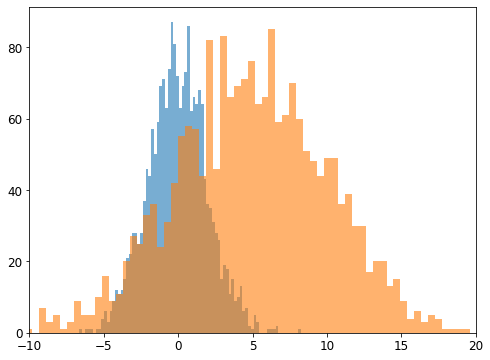

In [5]:
# generate some random data to work with
np.random.seed(2)
x1 = np.random.normal(0, 2, size = 2000)
x2 = np.random.normal(5, 5, size = 2000)
data = [x1, x2]

def plot_hist(data):
    for x in data:
        #plt.hist(x, bins = 80, normed = True, alpha = 0.6)
        plt.hist(x, bins = 80, alpha = 0.6)

    plt.xlim(-10, 20)

plot_hist(data)

Well, since we know which data came from which Gaussian distribution, all we need to do is to compute the mean and the variance for both groups and lo and behold we get our estimates for the two Gaussian.

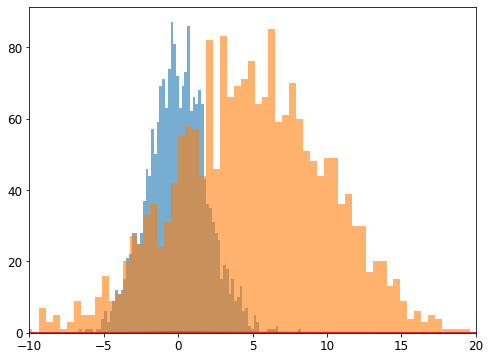

In [6]:
# estimate the mean and variance of the data
x1_mean, x1_var = np.mean(x1), np.var(x1)
x2_mean, x2_var = np.mean(x2), np.var(x2)
x_mean = [x1_mean, x2_mean]
x_var = [x1_var, x2_var]

def plot_guassian(x_mean, x_var):
    """
    note that scipy's normal distribution requires the
    standard deviation (square root of variance) 
    instead of the variance
    """
    x = np.linspace(start = -10, stop = 20, num = 200)
    for m, v in zip(x_mean, x_var):
        y = norm(m, np.sqrt(v)).pdf(x)
        plt.plot(x, y)

plot_hist(data)
plot_guassian(x_mean, x_var)

That's great!! But this is all based on knowing which points came from which distribution. Now, what if we have just a bunch of data points, we don't know which one came from which source. Can we trace back these guassian sources? Hmm ..., a bit trickier isn't it? On the other hand, what if someone came along and actually told us the parameters for the Gaussian, then we could actually figure out which points is more likely to come from which Gaussian. Given these information, we know have a chicken and egg problem. If someone told us which point came from which source, we can easily estimate the means and variance. Or if someone told us the mean and the variance for the Gaussians then we can figure out the probability of each point coming from each Gaussians. Unfortunately, we have neither .....

This is the exact situation we're in when doing **GMM**. We have a bunch of data points, we suspect that they came from $K$ different guassians, but we have no clue which data points came from which guassian. To solve this problem, we use the **EM algorithm**. The way it works is that it will start by placing guassians randomly (generate random mean and variance for the guassian). Then it will iterate over these two steps until it converges.

- **E step:** With the current means and variances, it's going to figure out the probability of each data point $x_i$ coming from each guassian.
- **M step:** Once it computed these probability assignments it will use these numbers to re-estimate the guassians' mean and variance to better fit the data points.

### E Step

We'll now formalize this. Recall that **GMM**'s goal is to output a set of soft assignments per data point (allocating the probability of that data point belonging to each one of the clusters). To begin with, let's just assume we actually know the parameters $\pi_k$, $\mu_k$ and $\Sigma_k$ (from some random initialization) and we need a formula to compute the soft assignments having fixed the values of all the other parameters.

$$r_{ik} = \frac{ \pi_k N(x_i \mid \mu_k,\Sigma_k) }{ \sum_{j=1}^K \pi_j N(x_i \mid \mu_j,\Sigma_j) }$$

Let's break this down piece by piece. The soft assignments are quantified by the responsibility vector $r$. For each observation $i$, we form a responsibility vector with elements $r_{i1}$, $r_{i2}$, all the way up to $r_{iK}$. Where $K$ is the total number of clusters, or often referred to as the number of components. The cluster responsibilities for a single data point $i$ should sum to 1.

The name Mixture of Gaussians comes from the notion that, in order to model more complex data distribution, we can use a linear combination of several Gaussians instead of using just one. To compute the mixture of Gaussians, we introduce a set of cluster weights, $\pi_k$, one for each cluster $k$. Where $\sum_{k=1}^K \pi_k = 1$ and $0 \leq \pi_k \leq 1$ (meaning that the sum must add up to one and each of them is between 0 and 1). This parameter tells us what's the prior probability that the data point in our data set $x$ comes from the $k_{th}$ cluster. We can think it as controlling each cluster's size.

The next part of the equation, $N(x_i \mid \mu_k,\Sigma_k)$ tells us: Given that we knew that the observation comes from the $k_{th}$ cluster, what is the likelihood of observing our data point $x_i$ coming from this cluster. To compute this part, the scipy package provides a convenient function `multivariate_normal.pdf` that computes the likelihood of seeing a data point in a multivariate Gaussian distribution.

After multiplying the prior and the likelihood, we need to normalize over all possible cluster assignments so that the responsibility vector becomes a valid probability. And this is essentially the computation that's done for the E step.

### M Step

After computing the responsibility vector for the current iteration, we then use it to update **GMM**'s parameter.

$$
\begin{align*}
N_k^{soft} &= \sum_{i=1}^N r_{ik} \\ \nonumber
\pi_k &= \frac{N_k^{soft}}{N_k} \\ \nonumber
\hat{\mu}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} x_i \\ \nonumber
\hat{\Sigma}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_i-\hat{\mu}_k)(x_i - \hat{\mu}_k)^T \nonumber
\end{align*}
$$

First, the cluster weights $\pi_k$, show us how much each cluster is represented over all data points (each cluster's relative size). This weight is given by the ratio of the soft count $N^{\text{soft}}_{k}$ over the total number of data points $N$.

When updating our parameters' estimates for each cluster $k$, we need to account for the associated weights $r_{ik}$ for every one of our observation. So every time we're touching a data point $x_i$ it's going to be multiplied by $r_{ik}$.

Another thing that's worth noticing is that, when we're updating the parameter $\hat{\mu}_k$ and $\hat{\Sigma}_k$, instead of dividing the summation with the raw count of the total number of data points in that cluster $N_k$, we will use the effective number of observations in that cluster (the sum of the responsibilities in that cluster) as the denominator. This is denoted as $N_k^{soft}$.  

## Assessing Convergence

Apart from training the model, we also want a way to monitor the convergence of the algorithm. We do so by computing the log likelihood of the data given the current estimates of our model parameters and responsibilities.

Recall that during the E step of the algorithm, we used the formula:

$$\sum_{j=1}^K \pi_j N(x_i \mid \mu_j,\Sigma_j)$$

To compute the weighted probability of our data point $x_i$ coming from each cluster $j$ and summed up all the weighted probability. If we were to assume the observed data points were generated independently, the likelihood of the data can be written as:

$$p(X \mid \pi, \mu,\Sigma)=\prod_{n=1}^{N} \sum_{j=1}^K \pi_j N(x_i \mid \mu_j,\Sigma_j)$$

This basically means that we multiply all the probability for every data point together to obtain a single number that estimates the likelihood of the data fitted under the model's parameter. We can take the log of this likelihood so that the product becomes a sum and it makes the computation a bit easier:

$$
ln \left( p(X \mid \pi,\mu,\Sigma) \right) = \sum^N_{i=1} ln\{\sum^K_{j=1}\pi_j
N (x_i \mid \mu_j,\Sigma_j)\}
$$

Given this formula, we can use it and say: If the log likelihood of the data occuring under the current model's parameter does not improve by a tolerance value that we've pre-specified, then the algorithm is deemed converged.

## Implementing the EM algorithm

To help us develop and test our implementation, we first generate some observations from a mixture of Gaussians.

In [7]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

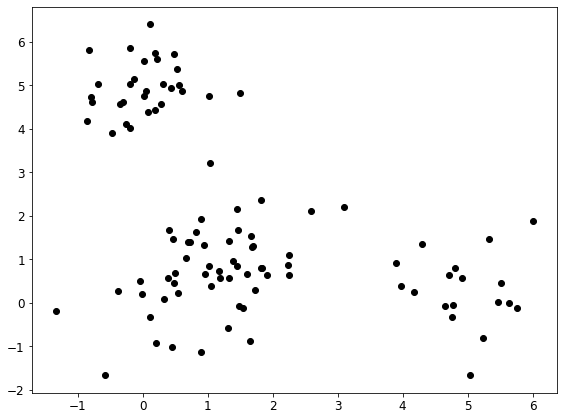

In [8]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(4)
X = generate_data(100, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()

Just like with K-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, the implementation below take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters. On the other hand, a better way to initial the GMM parameters is to use K-means as a first step and use its mean/cov of those clusters to initialize EM.

**Note**. Like K-means, EM is prone to converging to a local optimum if the initial set of parameters are sub-par. In practice, we may want to run EM multiple times with different random initialization.

In [9]:
class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

Next, we will run our EM algorithm to discover the mixture components and visualize its output. When working with low-dimensional data, one useful way of testing our implementation is to visualize the gaussian components over the data at different points in the algorithm's execution:

- At initialization
- After running the algorithm to completion (convergence)

In [10]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

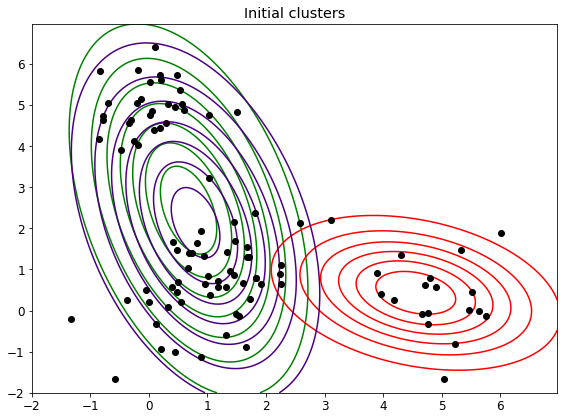

In [11]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
gmm = GMM(n_components = 3, n_iters = 1, tol = 1e-4, seed = 4)
gmm.fit(X)

plot_contours(X, gmm.means, gmm.covs, 'Initial clusters')

converged iteration: 23


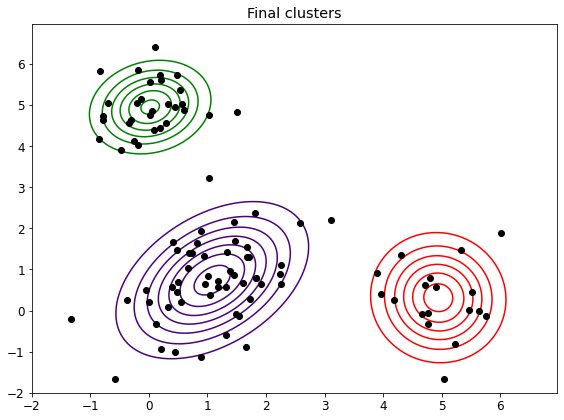

In [12]:
gmm = GMM(n_components = 3, n_iters = 50, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')

From the plot of different iterations in the EM algorithms, one can see that the Gaussian model is incrementally updated and refined to fit the data and the algorithm converged before it reached the maximum iteration that we've specified.

converged or not:  True


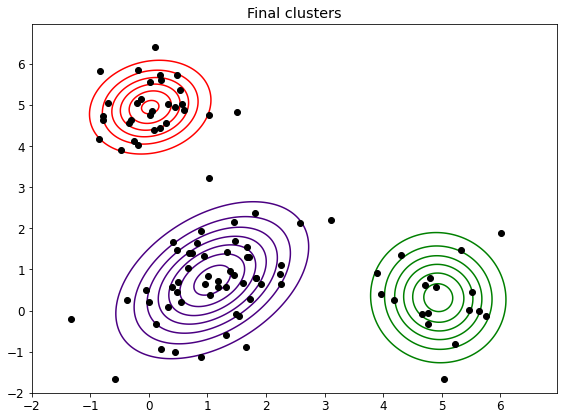

In [13]:
# use library to confirm results
gmm = GaussianMixture(n_components = 3, covariance_type = 'full', 
                      max_iter = 600, random_state = 3)
gmm.fit(X)

print('converged or not: ', gmm.converged_)
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')

## How many Gaussians?

Similar to K-means, **GMM** requires the user to specify the number of components (clusters) before training the model. Here, we can use the [**Aikaki Information Criterion (AIC)**](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [**Bayesian Information Criterion (BIC)**](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to aid us in this decision. Let $L$ be the maximum value of the likelihood function for the model, $p$ be the number of estimated parameters in the model and $N$ be the total number of data points.

Then the AIC value of the model is the following:

$$ \mathrm {AIC} =2  \cdot p - 2  \cdot \ln(L) $$

And the BIC value is denoted as:

$$ \mathrm{BIC} = {-2 \cdot \ln(L) + p \cdot \ln(N)}$$

For both evaluation criteron, the lower the better.

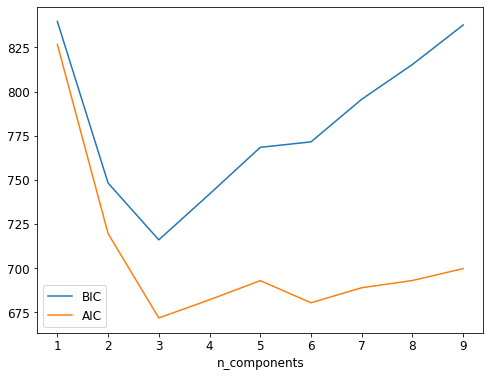

In [14]:
n_components = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter = 1000).fit(X) for n in n_components]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()
plt.show()

It appears that for both the AIC and BIC, 3 components is preferred.

> Advice taken from [Notes: AIC vs. BIC](https://methodology.psu.edu/node/504).
>
> In general, it might be best to use AIC and BIC together in model selection. Most of the times they will agree on the preferred model. The main differences between the two is that BIC penalizes model complexity more heavily. Thus if they do disagree. e.g. If BIC points to a three-class model and AIC points to a five-class model, it makes sense to select from models with 3, 4 and 5 latent classes and see which one leads to a more suitable result.

Another thing to bear in mind when looking at AIC/BIC evaluation metric is that all that matters is the difference between the AIC/BIC values. The actual value of the AIC/BIC and whether it is positive or negative, means nothing. So the bottom line is only pay attention to the difference.

**Things to Note:**

One drawback of **GMM** is that there are lots of parameters to learn, therefore may require lots of data and iterations to get good results. An unconstrained model with $K$-mixtures (or simply $K$ clusters) and $D$-dimensional data involves fitting $D \times D \times K + D \times K + K$ parameters ($K$ covariance matrices each of size $D \times D$, plus $K$ mean vectors of length $D$, plus a weight vector of length $K$). That could be a problem for datasets with large number of dimensions (e.g. text data), because with the number of parameters growing roughly as the square of the dimension, it may quickly become impossible to find a sufficient amount of data to make good inferences. So it is common to impose restrictions and assumption to simplify the problem (think of it as introducing regularization to avoid overfitting problems).

One common way to avoid this problem is to fix the covariance matrix of each component to be diagonal (off-diagonal value will be 0 and will not be updated). To achieve this, we can change the `covariance_type` parameter in scikit-learn's GMM to `diag`.

The following link includes an example of comparing **GMM** using different covariance matrices on a toy dataset, [sckit-learn docs: GMM classification](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py).

# Reference

- [Notes: Gaussians](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note08-2up.pdf)
- [Notes: AIC vs. BIC](https://methodology.psu.edu/node/504)
- [Youtube: Mixture Models Lecture](https://www.youtube.com/watch?v=REypj2sy_5U&list=PLBv09BD7ez_4e9LtmK626Evn1ion6ynrt)
- [Coursera: Washington Clustering & Retrieval](https://www.coursera.org/learn/ml-clustering-and-retrieval)
- [Notebooks: Density Estimation Gaussian Mixture Models](http://nbviewer.jupyter.org/github/jakevdp/sklearn_tutorial/blob/master/notebooks/04.3-Density-GMM.ipynb)
- [Stackoverflow: Negative values for AICc](https://stats.stackexchange.com/questions/486/negative-values-for-aicc-corrected-akaike-information-criterion)
- [Stackoverflow: Understanding concept of Gaussian Mixture Models](http://stackoverflow.com/questions/26019584/understanding-concept-of-gaussian-mixture-models)